# **1. Kết nối với google drive**

In [1]:
# kết nối với gg drive
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/NLP 4+1/Cuối kỳ/pre-trained/')
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1bs2wermM-w1hKEOcHyv-UmLHY5iag5cm/NLP 4+1/Cuối kỳ/pre-trained'

# **2. Install và import các thư viện cần thiết**

In [2]:
!pip install transformers --quiet
!pip install keras_preprocessing --quiet
!pip install pyvi --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00


In [3]:
import os
import re
import time
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyvi import ViTokenizer
from keras.models import load_model
from keras_preprocessing.sequence import pad_sequences
# from transformers import GPT2LMHeadModel, BertLMHeadModel

import nltk
nltk.download('punkt')

from nltk import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu, corpus_bleu

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **3. Set các biến cục bộ và load dữ liệu**

In [4]:
def preprocess(text):
    text = text.lower()                                                 # chuyển về chữ thường
    text = re.sub(r'[!“”"’#$%&\()*+,./:;<=>?@[\]^_`{|}~]', "", text)    # loại bỏ kí tự đặt biệt
    text = ViTokenizer.tokenize(text)                                   # word segmentation
    return text

In [5]:
# saving
def save_file(data, path):
    with open(path + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
def load_file(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **4. Load pre-trained cho các model**

## ***4.1 Model GPT***

In [7]:
tokenizer_GPT = load_file('./GPT/tokenizer.pickle')
model_GPT = load_file('./GPT/GPT2LMHeadModel.pickle')

In [8]:
model_GPT.resize_token_embeddings(len(tokenizer_GPT))
model_GPT = model_GPT.to(device)
if device == 'cpu':
    model_GPT.load_state_dict(torch.load('./GPT/model_GPT.pt', map_location ='cpu'))
else:
    model_GPT.load_state_dict(torch.load('./GPT/model_GPT.pt'))

In [9]:
def GPT_answer(inp, tokenizer=tokenizer_GPT, model=model_GPT):
    inp = '<s> '+ preprocess(inp) +" <bot>: "
    inp = tokenizer(inp, return_tensors="pt")
    X = inp["input_ids"].to(device)
    mask = inp["attention_mask"].to(device)
    output = model.generate(X, attention_mask=mask, max_length=32, pad_token_id=0, eos_token_id=50256)
    output = tokenizer.decode(output[0])
    try:
        result = re.search(r'<bot>:(.*?)</s>', output).group(1).strip()
    except:
        result = re.search(r'<bot>:\s*(.*)', output).group(1).strip()
    return result

In [10]:
GPT_answer("bạn có người yêu chưa")

'mình chưa có người_yêu bạn nhé'

## ***4.2 Model LSTM***

In [11]:
# LSTM (100 epoch)
tokenizer_LSTM_100 = load_file( './LSTM (100 epoch)/tokenizer.pickle')
enc_model_LSTM_100 = load_model('./LSTM (100 epoch)/enc_model.h5')
dec_model_LSTM_100 = load_model('./LSTM (100 epoch)/dec_model.h5')

# LSTM (200 epoch)
tokenizer_LSTM_200 = load_file( './LSTM (200 epoch)/tokenizer.pickle')
enc_model_LSTM_200 = load_model('./LSTM (200 epoch)/enc_model.h5')
dec_model_LSTM_200 = load_model('./LSTM (200 epoch)/dec_model.h5')

# LSTM + Attention (100 epoch)
tokenizer_LSTM_Attention_100 = load_file( './LSTM + Attention (100 epoch)/tokenizer.pickle')
enc_model_LSTM_Attention_100 = load_model('./LSTM + Attention (100 epoch)/enc_model.h5')
dec_model_LSTM_Attention_100 = load_model('./LSTM + Attention (100 epoch)/dec_model.h5')

# LSTM + Attention (200 epoch)
tokenizer_LSTM_Attention_200 = load_file( './LSTM + Attention (200 epoch)/tokenizer.pickle')
enc_model_LSTM_Attention_200 = load_model('./LSTM + Attention (200 epoch)/enc_model.h5')
dec_model_LSTM_Attention_200 = load_model('./LSTM + Attention (200 epoch)/dec_model.h5')

In [12]:
# BiLSTM (100 epoch)
tokenizer_BiLSTM_100 = load_file( './BiLSTM (100 epoch)/tokenizer.pickle')
enc_model_BiLSTM_100 = load_model('./BiLSTM (100 epoch)/enc_model.h5')
dec_model_BiLSTM_100 = load_model('./BiLSTM (100 epoch)/dec_model.h5')

# BiLSTM (200 epoch)
tokenizer_BiLSTM_200 = load_file( './BiLSTM (200 epoch)/tokenizer.pickle')
enc_model_BiLSTM_200 = load_model('./BiLSTM (200 epoch)/enc_model.h5')
dec_model_BiLSTM_200 = load_model('./BiLSTM (200 epoch)/dec_model.h5')

# BiLSTM + Attention (100 epoch)
tokenizer_BiLSTM_Attention_100 = load_file( './BiLSTM + Attention (100 epoch)/tokenizer.pickle')
enc_model_BiLSTM_Attention_100 = load_model('./BiLSTM + Attention (100 epoch)/enc_model.h5')
dec_model_BiLSTM_Attention_100 = load_model('./BiLSTM + Attention (100 epoch)/dec_model.h5')

# BiLSTM + Attention (200 epoch)
tokenizer_BiLSTM_Attention_200 = load_file( './BiLSTM + Attention (200 epoch)/tokenizer.pickle')
enc_model_BiLSTM_Attention_200 = load_model('./BiLSTM + Attention (200 epoch)/enc_model.h5')
dec_model_BiLSTM_Attention_200 = load_model('./BiLSTM + Attention (200 epoch)/dec_model.h5')

In [15]:
MAXLEN_QUESTION = 15
MAXLEN_ANSWER = 15
def str_to_tokens(sentence, tokenizer):
    words = preprocess(sentence)
    tokens_list = tokenizer.texts_to_sequences([words])
    return pad_sequences(tokens_list, maxlen=MAXLEN_QUESTION,padding='post')
    
def LSTM_BiLSTM_answer(question, type_model, with_epochs):
    if with_epochs == 100:
        if type_model == 'LSTM':
            tokenizer, enc_model, dec_model = tokenizer_LSTM_100, enc_model_LSTM_100, dec_model_LSTM_100
        elif type_model == 'BiLSTM':
            tokenizer, enc_model, dec_model = tokenizer_BiLSTM_100, enc_model_BiLSTM_100, dec_model_BiLSTM_100
    elif with_epochs == 200:
        if type_model == 'LSTM':
            tokenizer, enc_model, dec_model = tokenizer_LSTM_200, enc_model_LSTM_200, dec_model_LSTM_200
        elif type_model == 'BiLSTM':
            tokenizer, enc_model, dec_model = tokenizer_BiLSTM_200, enc_model_BiLSTM_200, dec_model_BiLSTM_200

    states_values = enc_model.predict(str_to_tokens(question, tokenizer), verbose=0)
    empty_target_seq = np.zeros((1,1))
    empty_target_seq[0,0] = tokenizer.word_index['<s>']
    stop_condition = False
    generated_answer = ''
    while not stop_condition:
        dec_outputs, h, c = dec_model.predict([empty_target_seq]+states_values, verbose=0)
        sampled_word_index = np.argmax(dec_outputs[0,-1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != '</s>':
                    generated_answer += f'{word} '
                sampled_word = word

        if sampled_word == '</s>' or len(generated_answer.split()) > MAXLEN_ANSWER:
            stop_condition = True
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = sampled_word_index
        states_values = [h,c]

    return generated_answer.strip()

def LSTM_BiLSTM_Attention_answer(question, type_model, with_epochs):
    if with_epochs == 100:
        if type_model == 'LSTM':
            tokenizer, enc_model, dec_model = tokenizer_LSTM_Attention_100, enc_model_LSTM_Attention_100, dec_model_LSTM_Attention_100
        elif type_model == 'BiLSTM':
            tokenizer, enc_model, dec_model = tokenizer_BiLSTM_Attention_100, enc_model_BiLSTM_Attention_100, dec_model_BiLSTM_Attention_100
    elif with_epochs == 200:
        if type_model == 'LSTM':
            tokenizer, enc_model, dec_model = tokenizer_LSTM_Attention_200, enc_model_LSTM_Attention_200, dec_model_LSTM_Attention_200
        elif type_model == 'BiLSTM':
            tokenizer, enc_model, dec_model = tokenizer_BiLSTM_Attention_200, enc_model_BiLSTM_Attention_200, dec_model_BiLSTM_Attention_200

    values,h,c = enc_model.predict(str_to_tokens(question, tokenizer), verbose=0)
    empty_target_seq = np.zeros((1,1))
    empty_target_seq[0,0] = tokenizer.word_index['<s>']
    stop_condition = False
    generated_answer = ''

    while not stop_condition:
        dec_outputs, h_state,c_state = dec_model.predict([empty_target_seq]+[values,h,c], verbose=0)
        sampled_word_index = np.argmax(dec_outputs[0,-1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != '</s>':
                    generated_answer += f'{word} '
                sampled_word = word

        if sampled_word == '</s>' or len(generated_answer.split()) > MAXLEN_ANSWER:
            stop_condition = True
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = sampled_word_index
        h,c = h_state,c_state

    return generated_answer.strip()

In [16]:
print('LSTM (100 epochs):', LSTM_BiLSTM_answer('bạn có người yêu chưa?', type_model='LSTM', with_epochs=100))
print('LSTM (200 epochs):', LSTM_BiLSTM_answer('bạn có người yêu chưa?', type_model='LSTM', with_epochs=200))
print('LSTM + Attention (100 epochs):', LSTM_BiLSTM_Attention_answer('bạn có người yêu chưa?', type_model='LSTM', with_epochs=100))
print('LSTM + Attention (200 epochs):', LSTM_BiLSTM_Attention_answer('bạn có người yêu chưa?', type_model='LSTM', with_epochs=200))

LSTM (100 epochs): có
LSTM (200 epochs): tôi có người_yêu rồi
LSTM + Attention (100 epochs): có
LSTM + Attention (200 epochs): vẫn chưa


In [18]:
print('BiLSTM (100 epochs):', LSTM_BiLSTM_answer('bạn có người yêu chưa?', type_model='BiLSTM', with_epochs=100))
print('BiLSTM (200 epochs):', LSTM_BiLSTM_answer('bạn có người yêu chưa?', type_model='BiLSTM', with_epochs=200))
print('BiLSTM + Attention (100 epochs):', LSTM_BiLSTM_Attention_answer('bạn có người yêu chưa?', type_model='BiLSTM', with_epochs=100))
print('BiLSTM + Attention (200 epochs):', LSTM_BiLSTM_Attention_answer('bạn có người yêu chưa?', type_model='BiLSTM', with_epochs=200))

BiLSTM (100 epochs): có
BiLSTM (200 epochs): mình chưa có người_yêu
BiLSTM + Attention (100 epochs): mình không thích gì thế_giới lên kinh_tế
BiLSTM + Attention (200 epochs): mình có người_yêu rồi


# **5. Đánh giá model**

Để đánh giá model ở đây nhóm em sẽ đánh giá dự trên các tiêu chí
* ***đồ thị loss***: giá trị loss thu được từ quá trình huấn luyện
* ***time_train*** : thời gian huấn luyện
* ***time_test*** : thời gian dự đoán (model trả lời các câu hỏi)
* ***blue_score***: Điểm BLEU được tính bằng cách đếm số lượng mã thông báo đơn lẻ hoặc tiếp theo được chia sẻ giữa chuỗi được tạo và tham chiếu. N mã thông báo tiếp theo được gọi là “n-gram”. Unigram đề cập đến một mã thông báo duy nhất trong khi bi-gram đề cập đến các cặp mã thông báo và n-gram đề cập đến n mã thông báo tiếp theo. *Điểm nằm trong khoảng từ 0 đến 1, trong đó 1 có nghĩa là bản dịch hoàn toàn khớp và 0 hoàn toàn không khớp*

## ***5.1 Load dữ liệu đánh giá***

In [19]:
df_test = pd.read_csv('../dataset/test.csv')
df_test

,question,answer
0,bạn ở nhà_trọ một_mình à,không mình ở nhà_trọ với một_số người bạn của ...
1,cậu đang làm gì đó đừng kêu mình là cậu đang x...,sao cậu biết hay vậy dạo này có mấy bộ phim mớ...
2,bạn thân của bạn đi học hay đi làm,đi học mà vừa học vừa làm thêm
3,êu hương cái quỳnh thích ăn gì thế,quỳnh thích ăn bánh_tráng trộn
4,đi làm có vui không đồng_nghiệp thoải_mái không,vui lắm cậu đồng_nghiệp thoải_mái hòa đồng lắm
...,...,...
145,cho mượn con bồ đi chơi bữa coi,tao chém chết giờ
146,quan_điểm của bạn về yêu_đương thế_nào,mình thích người_yêu chung thủy và không cầu_kì
147,cánh_gà chiên nước_mắm làm_sao,chuẩn_bị cánh_gà với nước_mắm rồi chiên
148,học năm bao_nhiêu,năm 4


In [20]:
# tạo các list chứa tên nhằm map với các function đã tạo nhằm để dự đoán
name_fun = ['LSTM_100', 'LSTM_200', 'LSTM_Attention_100', 'LSTM_Attention_200', 'BiLSTM_100', 'BiLSTM_200', 'BiLSTM_Attention_100', 'BiLSTM_Attention_200', 'GPT']
name_idx_model = ['LSTM (100 epoch)', 'LSTM (200 epoch)', 'LSTM + Attention (100 epoch)', 'LSTM + Attention (200 epoch)',
                  'BiLSTM (100 epoch)', 'BiLSTM (200 epoch)', 'BiLSTM + Attention (100 epoch)', 'BiLSTM + Attention (200 epoch)', 'GPT']

In [21]:
# load dữ liệu thu được từ quá trình training (loss, time_train)
compare = {}
for name_model in name_idx_model:
    val_compare = load_file(f'./{name_model}/val_compare.pickle')
    compare[name_model] = val_compare

## ***5.2 Xây dựng hàm để đánh giá các model***

In [22]:
def evaluation_model(df, name_model):
    # bot answer
    t0 = time.time()
    if name_model == 'LSTM_100':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_answer(inp, type_model='LSTM', with_epochs=100))
    elif name_model == 'LSTM_200':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_answer(inp, type_model='LSTM', with_epochs=200))
    elif name_model == 'LSTM_Attention_100':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_Attention_answer(inp, type_model='LSTM', with_epochs=100))
    elif name_model == 'LSTM_Attention_200':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_Attention_answer(inp, type_model='LSTM', with_epochs=200))
    elif name_model == 'BiLSTM_100':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_answer(inp, type_model='BiLSTM', with_epochs=100))
    elif name_model == 'BiLSTM_200':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_answer(inp, type_model='BiLSTM', with_epochs=200))
    elif name_model == 'BiLSTM_Attention_100':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_Attention_answer(inp, type_model='BiLSTM', with_epochs=100))
    elif name_model == 'BiLSTM_Attention_200':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_BiLSTM_Attention_answer(inp, type_model='BiLSTM', with_epochs=200))
    elif name_model == 'GPT':
        df['bot_answer'] = df['question'].apply(lambda inp: GPT_answer(inp))
    time_test = time.time() - t0
   
    # compute blue_score
    df['blue_score'] = df.apply(lambda row: sentence_bleu([word_tokenize(row['answer'])],
                                                          word_tokenize(row['bot_answer']),
                                                          weights=(0.333, 0.333, 0.334),
                                                          smoothing_function=SmoothingFunction().method1), axis=1)
    average_blue_score = df['blue_score'].sum()/len(df)
    
    return  time_test, average_blue_score

In [23]:
# bot answer for evaluation
for i in range(len(name_fun)):
    print(name_fun[i])
    time_test, blue_score = evaluation_model(df_test, name_fun[i])
    compare[name_idx_model[i]]['time_test'] = time_test
    compare[name_idx_model[i]]['blue_score'] = blue_score

LSTM_100
LSTM_200
LSTM_Attention_100
LSTM_Attention_200
BiLSTM_100
BiLSTM_200
BiLSTM_Attention_100
BiLSTM_Attention_200
GPT


## ***5.3 Biểu đồ thể hiện loss của các model trong quá trình training***

In [24]:
df_compare = pd.DataFrame(compare).T
df_compare

,loss_history,time_train,time_test,blue_score
LSTM (100 epoch),"[5.27993106842041, 4.832460880279541, 4.742298...",861.974908,59.923466,0.065846
LSTM (200 epoch),"[5.293466091156006, 4.827804088592529, 4.73371...",1833.314933,87.422664,0.068385
LSTM + Attention (100 epoch),"[5.152490615844727, 4.615281581878662, 4.37735...",901.991112,60.529492,0.058626
LSTM + Attention (200 epoch),"[5.15081787109375, 4.633525371551514, 4.401858...",1969.379817,73.28996,0.055258
BiLSTM (100 epoch),"[5.266211032867432, 4.811457633972168, 4.70604...",1070.257996,58.806759,0.056039
BiLSTM (200 epoch),"[5.256855487823486, 4.809628486633301, 4.70807...",2189.475095,54.429996,0.079838
BiLSTM + Attention (100 epoch),"[5.193233489990234, 4.641602039337158, 4.43003...",1123.700434,66.721872,0.063574
BiLSTM + Attention (200 epoch),"[5.155731201171875, 4.640689373016357, 4.42633...",2252.172049,62.724912,0.041095
GPT,"[2.9926091897345724, 2.0031412453168915, 1.629...",10104.958626,42.399649,0.069396


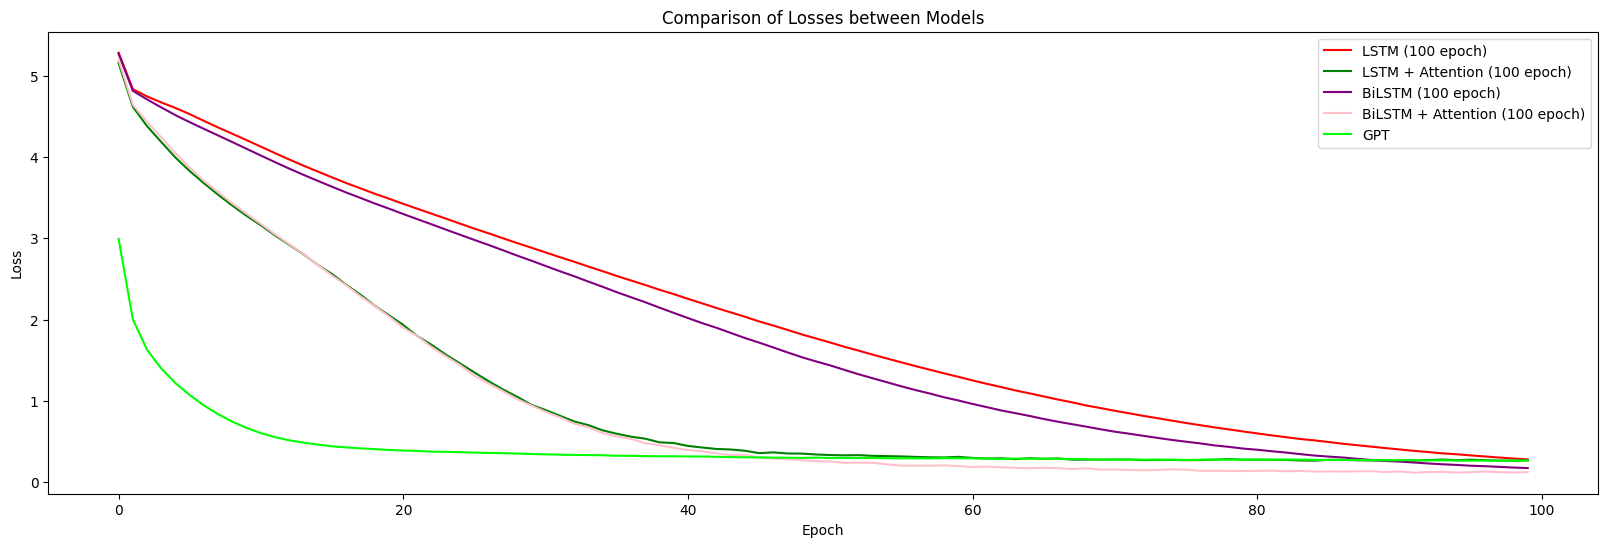

In [25]:
plt.figure(figsize=(20,6))
# Tạo một list chứa các màu sắc để sử dụng cho từng model
colors = ["red", "blue", "green", "brown", "purple", "orange", "pink", "olive", "lime"]

# Vẽ đồ thị loss cho mỗi model
for i, model_name in enumerate(df_compare.index):
    if '200' not in model_name:
        loss_history = df_compare.loc[model_name, "loss_history"]
        epochs = len(loss_history)
        plt.plot(np.arange(epochs), loss_history, label=model_name, color=colors[i])

# Thiết lập các thông số cho đồ thị
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Losses between Models")
plt.legend()

# Hiển thị đồ thị
plt.show()

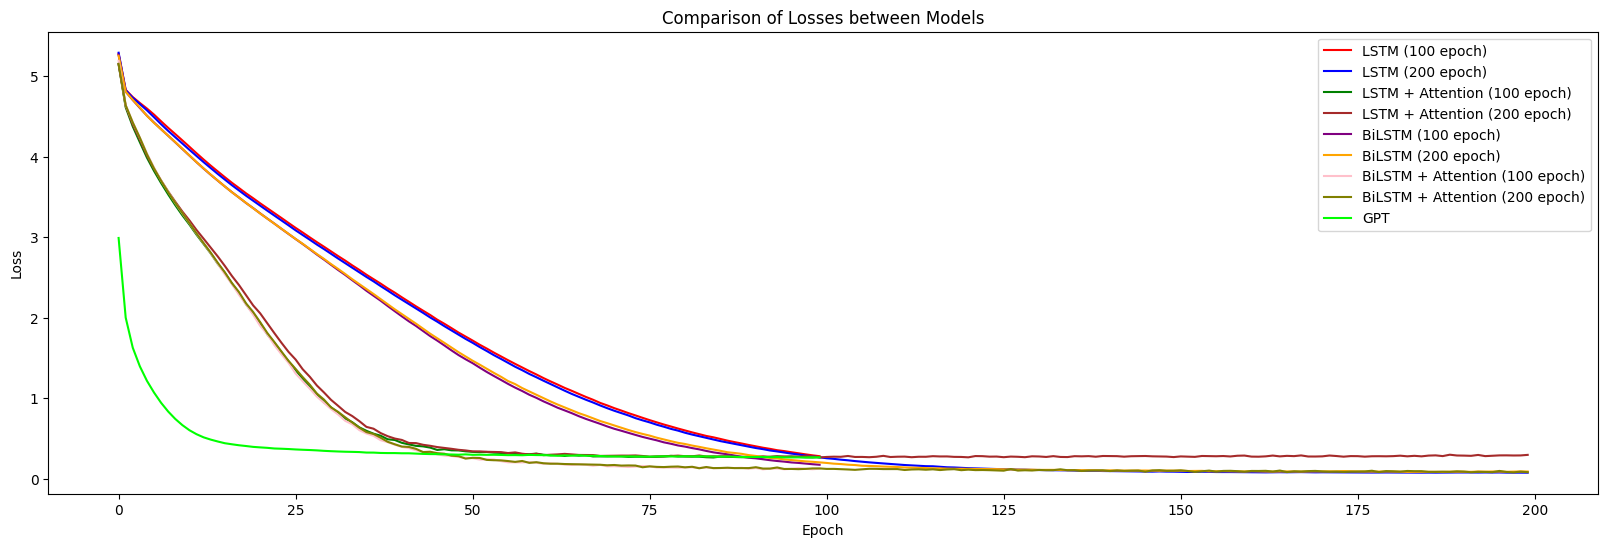

In [26]:
plt.figure(figsize=(20,6))
# Tạo một list chứa các màu sắc để sử dụng cho từng model
colors = ["red", "blue", "green", "brown", "purple", "orange", "pink", "olive", "lime"]

# Vẽ đồ thị loss cho mỗi model
for i, model_name in enumerate(df_compare.index):
    loss_history = df_compare.loc[model_name, "loss_history"]
    epochs = len(loss_history)
    plt.plot(np.arange(epochs), loss_history, label=model_name, color=colors[i])

# Thiết lập các thông số cho đồ thị
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Losses between Models")
plt.legend()

# Hiển thị đồ thị
plt.show()

## ***5.4 Biểu đồ so sánh các độ đo khác (time_train, time_test, blue_score)***

In [27]:
df_compare = df_compare.drop(['loss_history'], axis=1)
df_compare.style.highlight_max(color = 'green', axis = 0, subset=['blue_score']
                ).highlight_min(color = 'red', axis = 0, subset=['time_train','time_test'])

,time_train,time_test,blue_score
LSTM (100 epoch),861.974908,59.923466,0.065846
LSTM (200 epoch),1833.314933,87.422664,0.068385
LSTM + Attention (100 epoch),901.991112,60.529492,0.058626
LSTM + Attention (200 epoch),1969.379817,73.289960,0.055258
BiLSTM (100 epoch),1070.257996,58.806759,0.056039
BiLSTM (200 epoch),2189.475095,54.429996,0.079838
BiLSTM + Attention (100 epoch),1123.700434,66.721872,0.063574
BiLSTM + Attention (200 epoch),2252.172049,62.724912,0.041095
GPT,10104.958626,42.399649,0.069396


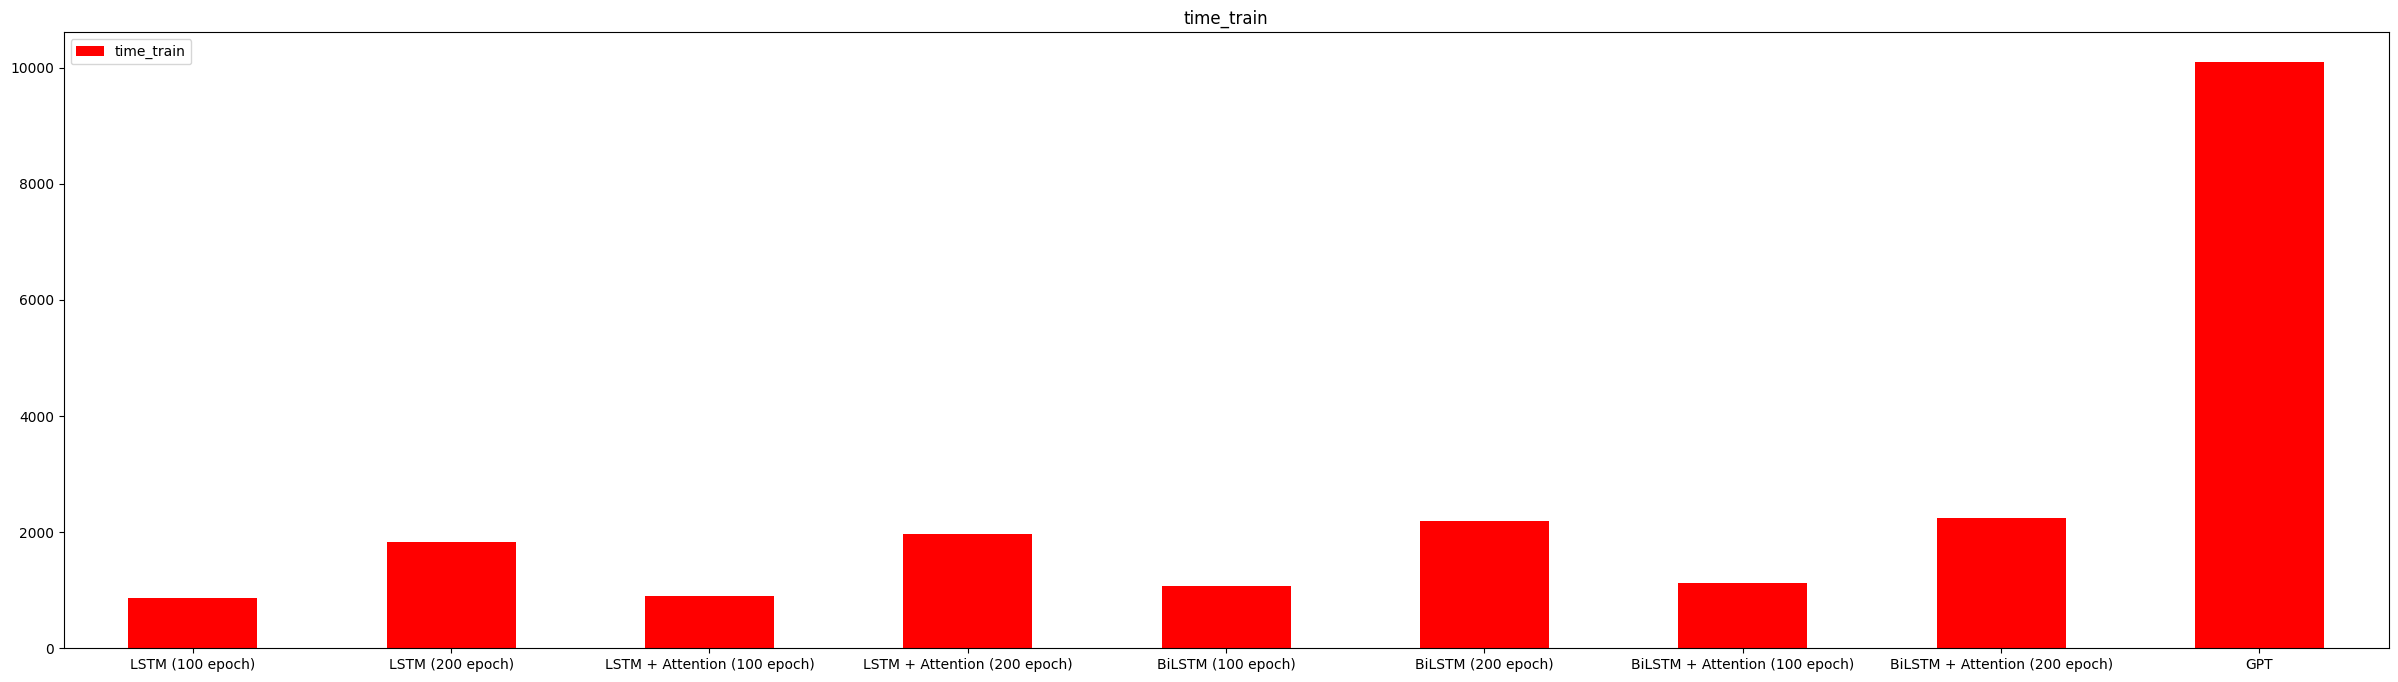

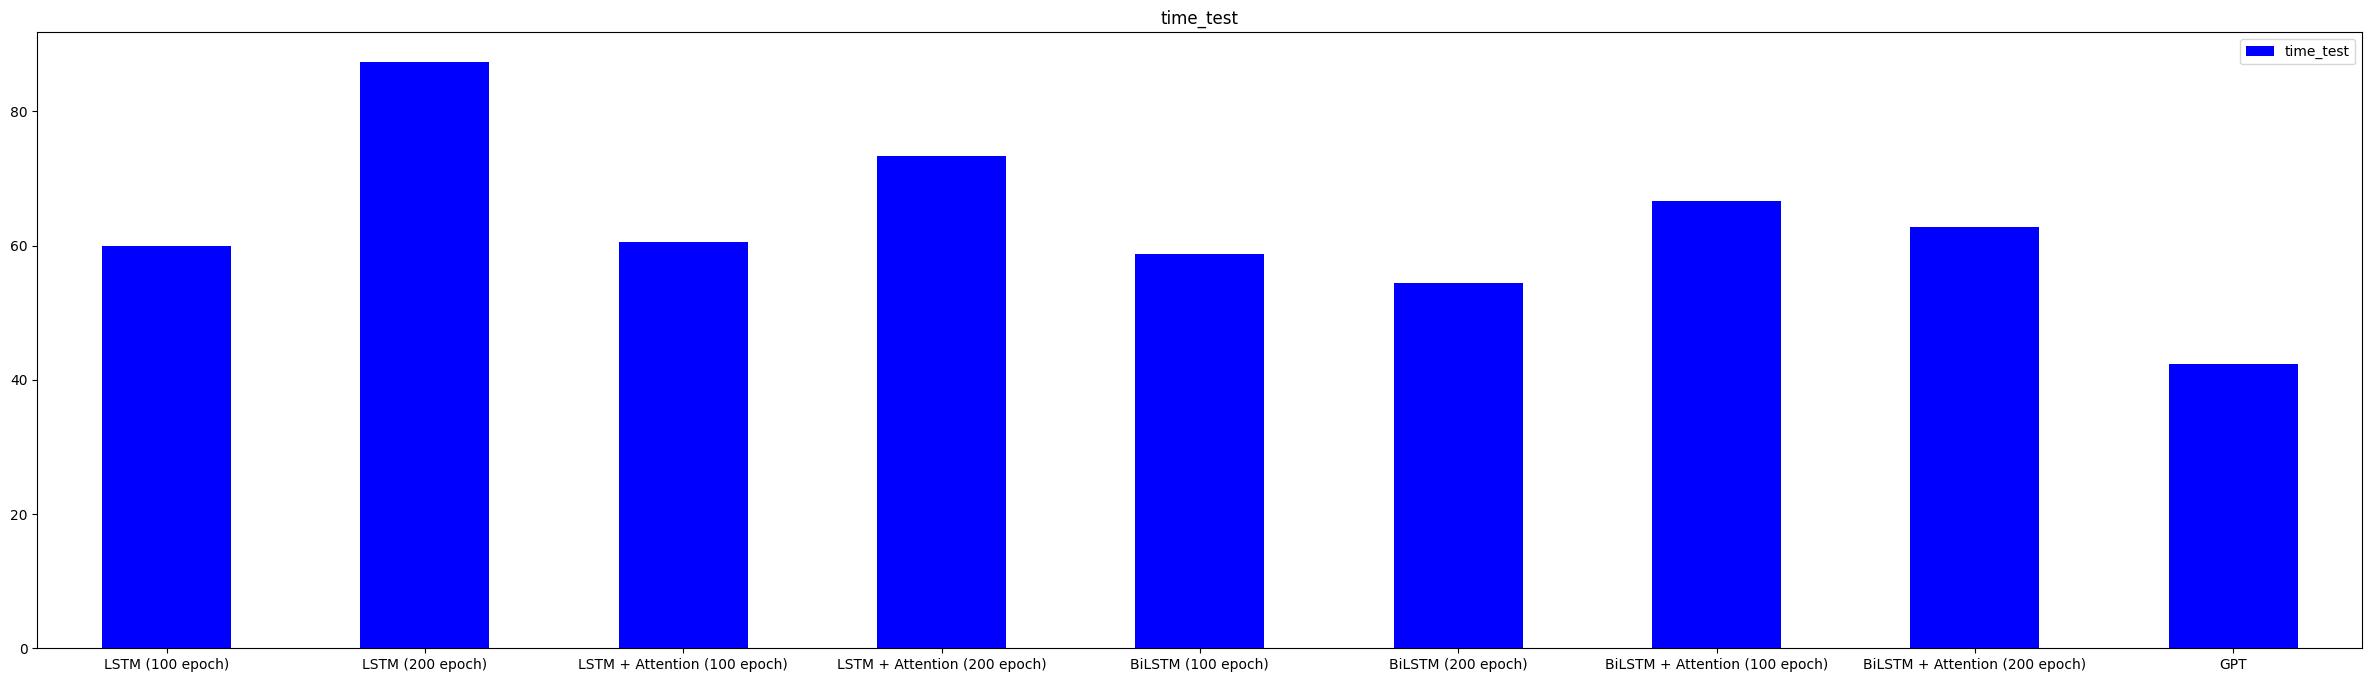

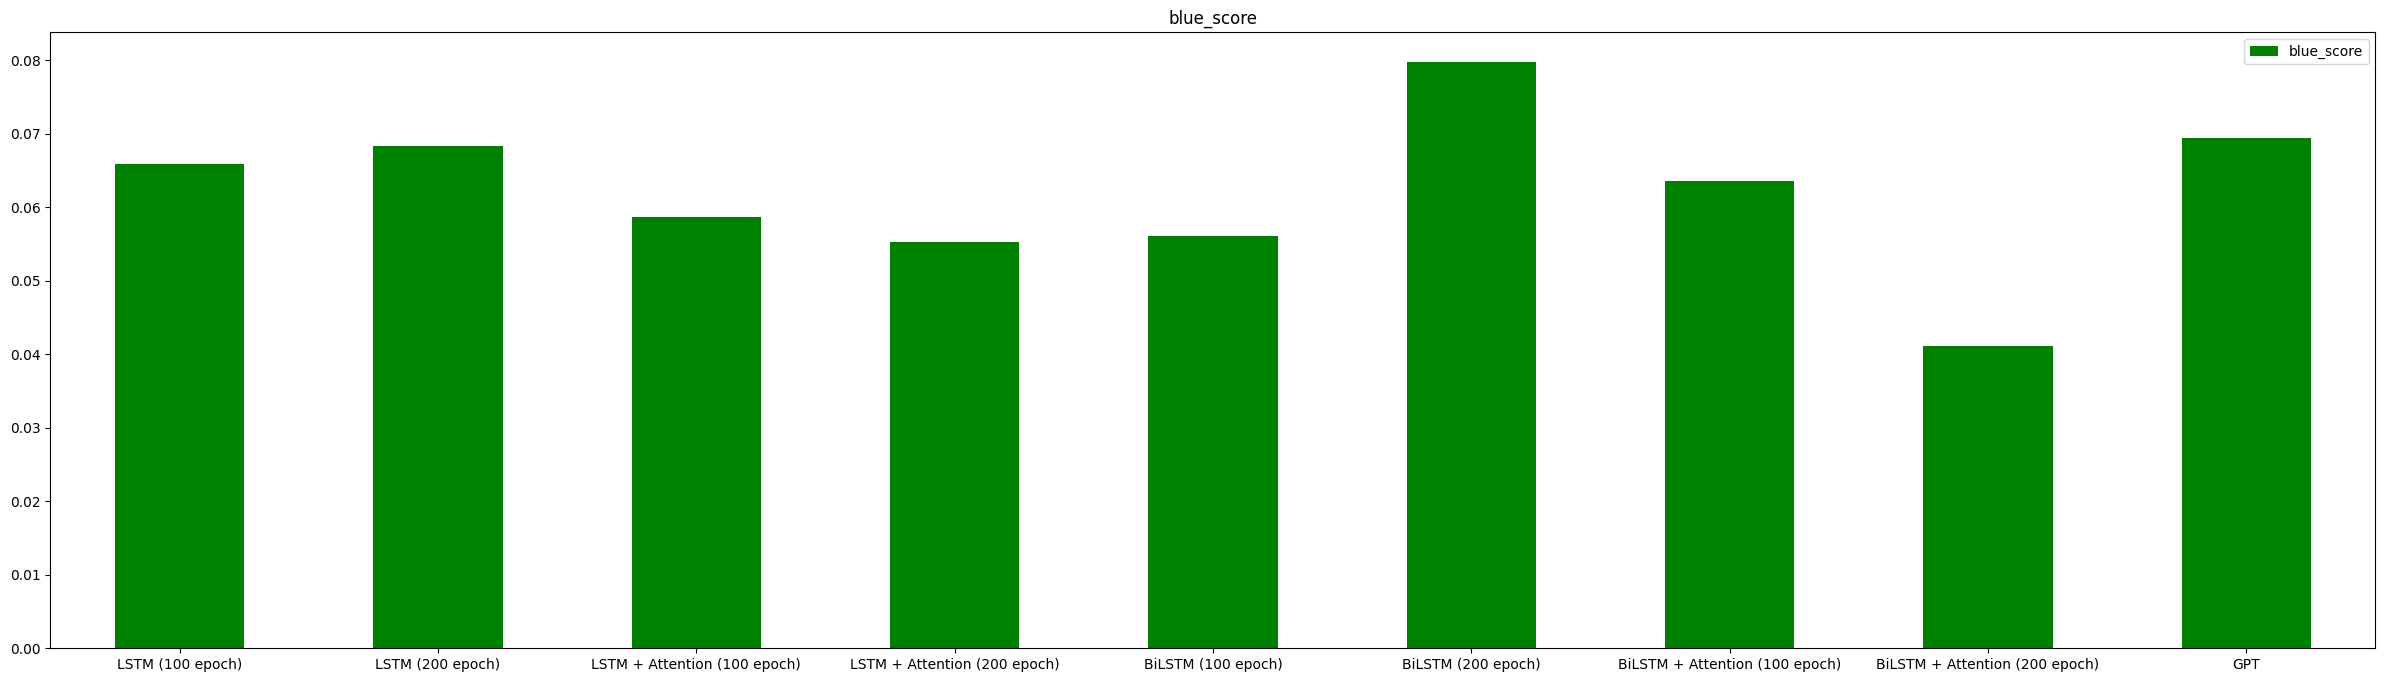

In [50]:
for i, col in enumerate(df_compare.columns):
    df_compare.plot(kind= 'bar', y=col, title=col, rot=0, figsize=(30,8), color=colors[i])

# **6. Show answer**

In [43]:
def show_bot_answer(i):
    question = df_test.iloc[i]['question']
    actual_answer = df_test.iloc[i]['answer']

    print('question                  :', question)
    print('actual answer             :', actual_answer)
    print('(LSTM 100)                :', LSTM_BiLSTM_answer(question, type_model='LSTM', with_epochs=100)) 
    print('(LSTM 200)                :', LSTM_BiLSTM_answer(question, type_model='LSTM', with_epochs=200))
    print('(LSTM + Attention 100)    :', LSTM_BiLSTM_Attention_answer(question, type_model='LSTM', with_epochs=100)) 
    print('(LSTM + Attention 200)    :', LSTM_BiLSTM_Attention_answer(question, type_model='LSTM', with_epochs=200)) 
    print('(BiLSTM 100)              :', LSTM_BiLSTM_answer(question, type_model='BiLSTM', with_epochs=100)) 
    print('(BiLSTM 200)              :', LSTM_BiLSTM_answer(question, type_model='BiLSTM', with_epochs=200))
    print('(BiLSTM + Attention 100)  :', LSTM_BiLSTM_Attention_answer(question, type_model='BiLSTM', with_epochs=100)) 
    print('(BiLSTM + Attention 200)  :', LSTM_BiLSTM_Attention_answer(question, type_model='BiLSTM', with_epochs=200)) 
    print('(GPT)                     :', GPT_answer(question)) 

In [44]:
show_bot_answer(1)

question                  : cậu đang làm gì đó đừng kêu mình là cậu đang xem phim nha
actual answer             : sao cậu biết hay vậy dạo này có mấy bộ phim mới ra hay lắm
(LSTM 100)                : tớ cũng muốn đang đi ăn_ở
(LSTM 200)                : tớ giống loại ghê
(LSTM + Attention 100)    : đúng rồi cậu bạn làm gì là tao được không
(LSTM + Attention 200)    : cậu không chọn phim đi
(BiLSTM 100)              : cậu muốn hay hay đi bạn ơi
(BiLSTM 200)              : tớ cũng hay hay ra thôi
(BiLSTM + Attention 100)  : được cậu ơi
(BiLSTM + Attention 200)  : ừ mình cũng đang coi dĩ_nhiên không
(GPT)                     : sao cậu biết hay vậy dạo này có mấy bộ phim mới ra hay lắm


In [45]:
show_bot_answer(7)

question                  : ê đi chơi không
actual answer             : đi chứ
(LSTM 100)                : không
(LSTM 200)                : có
(LSTM + Attention 100)    : có
(LSTM + Attention 200)    : có
(BiLSTM 100)              : có
(BiLSTM 200)              : đi
(BiLSTM + Attention 100)  : covid
(BiLSTM + Attention 200)  : đi
(GPT)                     : có


In [46]:
show_bot_answer(9)

question                  : thích ăn gì trong khi xem phim
actual answer             : bổng ngô
(LSTM 100)                : trái_cây có phim
(LSTM 200)                : khoa_học viễn_tưởng
(LSTM + Attention 100)    : doremon
(LSTM + Attention 200)    : có chứ
(BiLSTM 100)              : ăn gà rán
(BiLSTM 200)              : món ăn gà rán
(BiLSTM + Attention 100)  : ăn gà mật_ong sữa mật_ong thời_tiết ma cuốn tiếu tìm toàn_thân
(BiLSTM + Attention 200)  : ăn thịt nướng lẩu
(GPT)                     : đọc sách nghe nhạc


In [47]:
show_bot_answer(10)

question                  : bạn có thích công_việc của mình không
actual answer             : mình không thích
(LSTM 100)                : không mình thích
(LSTM 200)                : không có
(LSTM + Attention 100)    : có
(LSTM + Attention 200)    : không nha bạn
(BiLSTM 100)              : có
(BiLSTM 200)              : không thích
(BiLSTM + Attention 100)  : không mình không thích bóng_rổ lắm
(BiLSTM + Attention 200)  : chắc_chắn là có chớ nhận lì_xì đi làm thêm mà
(GPT)                     : không mình thích công_việc của mình


In [48]:
show_bot_answer(11)

question                  : tối nay đi xem bóng_đá nhé
actual answer             : đang bận học bài
(LSTM 100)                : ok đi nè
(LSTM 200)                : tối nay nhỏ ở nhà
(LSTM + Attention 100)    : hoi tối go rồi
(LSTM + Attention 200)    : tối là bận rồi
(BiLSTM 100)              : tối nay tao bận việc lại rồi
(BiLSTM 200)              : ok
(BiLSTM + Attention 100)  : tối nay mình bận học web
(BiLSTM + Attention 200)  : tối nay mình bận việc gì tầm nay
(GPT)                     : tối nay mình đi


In [49]:
show_bot_answer(12)

question                  : chất son ổn không
actual answer             : ổn
(LSTM 100)                : quá deadline còn nếu cậu không cần vui
(LSTM 200)                : cũng được
(LSTM + Attention 100)    : buồn như sữa lại bạn nên không biết
(LSTM + Attention 200)    : có
(BiLSTM 100)              : còn
(BiLSTM 200)              : mình vừa học 2 môn ít_nhất môn bơi
(BiLSTM + Attention 100)  : xin sinh_viên rất tốt nha
(BiLSTM + Attention 200)  : giàu lắm bên core lò bất_kì tay luôn
(GPT)                     : ổn
